<a href="https://colab.research.google.com/github/cxbxmxcx/Evolutionary-Deep-Learning/blob/main/EDL_5_RS_HPO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
#@title Defining Imports
#numpy
import numpy as np
#PyTorch
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
#plotting
from matplotlib import pyplot as plt
from IPython.display import clear_output
#for performance timing
import time
#ranodm
import random

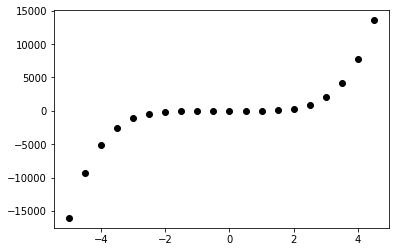

In [ ]:
def function(x):
  return (2*x + 3*x**2 + 4*x**3 + 5*x**4 + 6*x**5 + 10) 

data_min = -5
data_max = 5
data_step = .5
Xi = np.reshape(np.arange(data_min, data_max, data_step), (-1, 1))
yi = function(Xi)
inputs = Xi.shape[1]
yi = yi.reshape(-1, 1)
plt.plot(Xi, yi, 'o', color='black')

In [ ]:
#@title Define the Model
class Net(nn.Module):
  def __init__(self, inputs, middle):
    super().__init__()
    self.fc1 = nn.Linear(inputs,middle)    
    self.fc2 = nn.Linear(middle,middle)    
    self.out = nn.Linear(middle,1)
  def forward(self, x):
    x = F.relu(self.fc1(x))     
    x = F.relu(self.fc2(x))    
    x = self.out(x)
    return x

In [ ]:
#@title Define Hyperparameters Class
class Hyperparameters(object):
  def __init__(self, **kwargs):
    self.__dict__.update(kwargs)
  
  def __str__(self):
    out = ""
    for d in self.__dict__:
      ds = self.__dict__[d]
      out += f"{d} = {ds}\n"
    return out

  def next(self):
    dict = {}
    for d in self.__dict__:
      dict[d] = next(self.__dict__[d])
    return Hyperparameters(**dict)

def sampler(func, min, max):
  while True:
    yield func(min,max)

# Create the Hyperparameters

In [ ]:
#@title Instantiate Hyperparameters 
hp = Hyperparameters(
  epochs = sampler(random.randint,20,400),
  middle_layer = sampler(random.randint, 8, 64),  
  learning_rate = sampler(random.uniform,3.5e-01,3.5e-03),
  batch_size = sampler(random.randint, 4, 64)  
)

#sample
print(hp.next())

epochs = 305
middle_layer = 40
learning_rate = 0.04043063145242942
batch_size = 40



# Create the Training Function

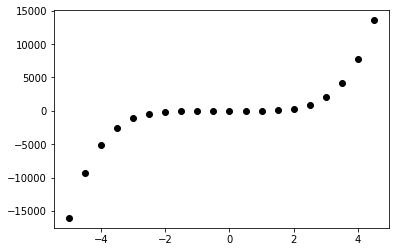

In [ ]:
def sample_train_function(hp):
  hp = hp.next() 
  
  X = np.reshape(
      np.arange(
          data_min, 
          data_max, 
          data_step)
      , (-1, 1))
  y = function(X)
  inputs = X.shape[1]
  y = y.reshape(-1, 1)
  plt.plot(X, y, 'o', color='black')

sample_train_function(hp)

20043.39453125


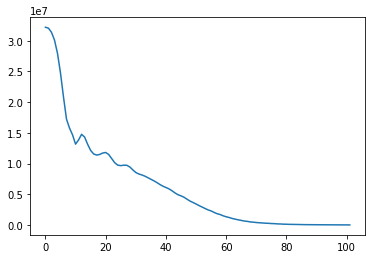

In [ ]:
#@title The Main Training Function
def train_function(hp, best):
  hp = hp.next()
 
  X = np.reshape(
      np.arange(
          data_min, 
          data_max, 
          data_step)
      , (-1, 1))
  y = function(X)
  inputs = X.shape[1]
  
  tensor_x = torch.Tensor(X) # transform to torch tensor
  tensor_y = torch.Tensor(y)
  
  dataset = TensorDataset(tensor_x,tensor_y) # create your datset
  dataloader = DataLoader(dataset, batch_size= hp.batch_size, shuffle=True) # create your dataloader

  model = Net(inputs, hp.middle_layer)

  loss_fn = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr=hp.learning_rate)
  history=[]  
  start = time.time()
  for i in range(hp.epochs):        
    for X, y in iter(dataloader):
      # wrap the data in variables
      x_batch = Variable(torch.Tensor(X))
      y_batch = Variable(torch.Tensor(y))                   
      # forward pass
      y_pred = model(x_batch)        
      # compute and print loss
      loss = loss_fn(y_pred, y_batch)  
      ll = loss.data
      history.append(ll)
      if ll < best and i>100:
        end = time.time() - start
        return end, history, model, hp               
      # reset gradients
      optimizer.zero_grad()        
      # backwards pass
      loss.backward()        
      # step the optimizer - update the weights
      optimizer.step()  
  end = time.time() - start
  return end, history, model, hp

best = float("inf")
span, history, model, hp_out = train_function(hp, best)
plt.plot(history)
print(min(history).item())

# Automatic HPO

Fitness 0.0007746219635009766


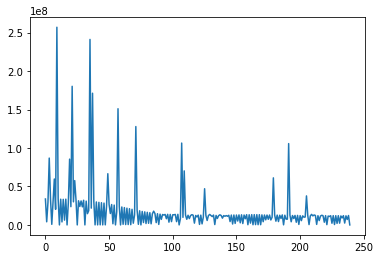

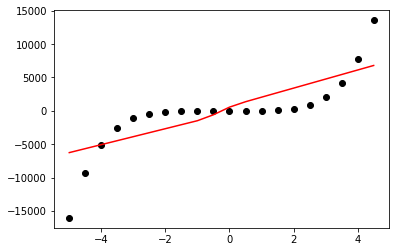

epochs = 287
middle_layer = 23
learning_rate = 0.03478635218404641
batch_size = 19



In [ ]:
#@title Run the HPO Automation
runs = 10000
best = float("inf")
for i in range(runs):
  span, history, model, hp_out = train_function(hp, best)
  fitness = history[-1].item() 
  if fitness < best:
    best = fitness
    clear_output()
    print(f"Fitness {fitness}")
    plt.plot(history)
    plt.show()
    plt.plot(Xi, yi, 'o', color='black')
    y_ = model(torch.Tensor(Xi))
    plt.plot(Xi,y_.detach().numpy(), 'r')
    plt.show()
    print(hp_out)
